In this exercise we are supposed to understand and implement Local sensitive hashing technique that is broadly used to approximate the similarity of different data sets. This topic involves many knowledges such as encoded bag of words, signature matrix, buckets, candiate pairs, random permutation hash function, and so on. 

LSH is a quite complicated topic, we will break it down to 4 steps:

1. make the encoded bag of words matrix M.
2. Using random permutation hash function to MinHash M to get the signature matrix SIG.
3. Construct candidate pairs by applying the LSH technique, and compare their similarity
4. Analysis of using different amount of random functions.

*Pre-operation on the raw marterials, Combine all the json files into one file.

In [ ]:
import json
import glob

result = []
for f in glob.glob("EX11_articles/*.json"):
    with open(f, "rb") as infile:
        result.append(json.load(infile))

with open("merged_file.json", "wb") as outfile:
     json.dump(result, outfile)

In [1]:
import json

with open('merged_file.json') as data_file:    
    data = json.load(data_file)

#data[0][2]['body']
t = []
for i in range(len(data)):
    for j in range(len(data[i])):
        if ('body' in data[i][j] and 'topics' in data[i][j]):
            t.append(data[i][j])

1. Make the encoded bag of words matrix M. we transpose the matrix, since it is easy to to MinHash later on. The shape of M is 32936L, 10377L

In [39]:
import collections, re
import numpy as np
all_words = {}
bagsofwords = [ collections.Counter(re.findall(r'\w+', txt['body'])) for txt in t]

i = 0
for c in bagsofwords:
    for w in c.elements():
        if w not in all_words:
            all_words[w] = i
            i += 1
# fixed amount of features/buckets
print len(all_words)
print np.shape(bagsofwords)
a = np.zeros((len(t), len(all_words)), dtype='int32')
#a = np.zeros((len(t), 1000), dtype='int32')

32936
(10377L,)


(32936L, 10377L)

loop for each bagsofwords(10377L) and for each iterm of the bagsofwords, counts for a word occurence, and insert it in the martix (10377L, 32936L).

In [ ]:
for i, c in enumerate(bagsofwords):
    for w, count in c.iteritems():
        a[i, all_words[w]] = count
        
#M = a.transpose()[:,0:100] # use 100 articles as an example
M = a.transpose()
np.shape(M)

In [256]:
from operator import itemgetter
import numpy as np
import random as rnd

len_buckets = 32936 #choice a prime number
hash_table = [[] for i in xrange(len_buckets)]

# construct array of bucket with band as row number and length of buckets as columns.
def initialize_array_bucket(bands):
    global len_buckets
    array_buckets = []
    for band in xrange(bands):
        array_buckets.append([[] for i in xrange(len_buckets)])
    return array_buckets
    

# hash function take random variables var, cons.
def hash_minHash(x,var,cons,n):
    return (var*x + cons) % n

# we should use the next prime number rather than the maximum shingling index to do modulo operation.
def generate_hash_functions(n):
    hash_funcs = []

    for i in xrange(n):
        var = rnd.randint(0,nestPrime)
        cons = rnd.randint(0,nestPrime)
        hash_funcs.append([var,cons])
    return hash_funcs

#2. Pick a length 'n' for the minHash signatures.
#That is, pick 'n'randomly chosen hash functions. 
# MinHash is a very efficient way to convert a huge data set to a small size called
# signature matrix whilst preserving the jaccard similarity between the columns,
# The signature matrix is small enough that the memory can store it.
# We pick 10 random permutations of the rows to generate 10 hash functions, we hash each
# row of the bag of words matrix to get "hash_value".
# The hash function h(C) = the number of the first row in which column C  has 1.
# for each row r 
#    for each column c 
#        if c is not 0 
#           for each hash function hi  do
#             if hi (r ) is a smaller value than M (i, c ) then M (i, c ) := hi (r );
                

def compute_minHash_signatures(matrix,n):
    hash_funcs = generate_hash_functions(n)
    #hash_funcs = [[1,0],[3,1],[4,3],[2,1],[9,0]]
    
    hash_value = []
    for func in hash_funcs:
        val = [hash_minHash(i,func[0],func[1],matrix.shape[0]) for i in xrange(matrix.shape[0])]
        hash_value.append(val)
    #print hash_value
    
    #signature matrix (SIG)
    SIG = np.zeros((n,matrix.shape[1])) + float('inf')

    for c in xrange(matrix.shape[1]):
        for r in xrange(matrix.shape[0]):
            if matrix[r,c] != 0:
                for i in xrange(n):
                    hi = hash_value[i]
                    SIG[i,c] = min(SIG[i,c],hi[r])
    return SIG

#L2-norm, that is, r = 2.0. 
def euclidean_distance(x,y,r=2.0):
    try:        
        return sum(((x[i] - y[i]) ** r) for i in xrange(len(x))) ** (1.0/r)
    
    except (ValueError,ZeroDivisionError):
        print 'Please, enter only even values for "r > 0".'
    except IndexError:
        print 'Please, the sets must have the same size.'
        
# A measure of cosine distance by using euclidean distance between a candidate pair, used to determine the similarity.
def cosine_distance(x,y):
    prodAB = sum([x[i]*y[i] for i in xrange(len(x))])
    zeros = [0 for i in xrange(len(x))]
    A = euclidean_distance(x,zeros)
    B = euclidean_distance(y,zeros)
    return prodAB / (A*B)

#3. Choose a threshold t that defines how similar documents have to be.
#   Construct candidate pairs by applying the LSH technique.
#   Examine each candidate pair's signatures and determine whether the fraction
#   of components in which they agree is at least t.
#   Pick a number of bands b and a number of rows r such that b*r = n,
#   and the threshold t is 0.8
#   The LSH idea is that hash columns of signature matrix SIG  several times.
#   Arrange that (only) similar columns are likely to hash to the same bucket.
#   Candidate pairs are those that hash at least once to the same bucket.

def apply_LSH_technique(SIG,t,bands,rows):
    if bands * rows != len(SIG):
        raise 'bands*rows must be equals to n :: bands*rows = n !!!'

    array_buckets = initialize_array_bucket(bands)

    hash_funcs = generate_hash_functions(bands)

    candidates = {}
    jaccard = {}
    
    i = 0
    for b in xrange(bands):
        buckets = array_buckets[b]        
        band = SIG[i:i+rows,:]
        for col in xrange(band.shape[1]):
            key = int(sum(band[:,col]) % len(buckets))          
            buckets[key].append(col)
        
        i = i+rows
        
# A,B are two columns of the signature matrix, and a,b are two colums in the encoded bag of words
# matrix. 
# we will compute two similarities. first, we compute the cosine distance and then jaccard distance 
# by using the same columns. We set a threshold 0.8, and put all pairs to candidate whose similarity 
# is bigger than 0.8. 
# Nest, we compare the cosine distance derived from LSH to the jaccard derived from original bag of
# words matrix.

        for item in buckets:
            #print 'buckets: ', item
            if len(item) > 1:
                pair = (item[0], item[1])
                #print 'pair: ', pair
                if pair not in candidates:
                    A = SIG[:,item[0]]
                    B = SIG[:,item[1]]
                    a= set(M[:,item[0]])
                    b= set(M[:,item[1]])
                    jac = float(len(a.intersection(b))) /float(len(a.union(b))) 
                    similarity = cosine_distance(A,B)
                    if similarity >= t:
                        candidates[pair] = similarity
                        jaccard[pair] = jac


    #print order by descending on the fraction of similarity
    lsh = sorted(candidates.items(),key=itemgetter(1), reverse=True)
    true_jaccard = sorted(jaccard.items(),key=itemgetter(1), reverse=True)

    return candidates, lsh, true_jaccard

if __name__ == '__main__':   
    MaxshinglesInd = 32936
    nestPrime =32941

    SIG_3 = compute_minHash_signatures(M,3)
    SIG_5 = compute_minHash_signatures(M,5)
    SIG_10 = compute_minHash_signatures(M,10)

    candidates_10,lsh_10, true_jaccard_10 = apply_LSH_technique(SIG_10,0.8,5,2)
    candidates_5,lsh_5, true_jaccard_5 = apply_LSH_technique(SIG_5,0.8,5,1)
    candidates_3,lsh_3, true_jaccard_3 = apply_LSH_technique(SIG_3,0.8,3,1)


The 20 most similar using 3 hash functions:
[((1973, 9593), 1.0000000000000002), ((253, 3050), 1.0000000000000002), ((2290, 5736), 1.0000000000000002), ((1273, 3072), 1.0000000000000002), ((1980, 1981), 1.0000000000000002), ((3606, 3639), 1.0000000000000002), ((7555, 7589), 1.0000000000000002), ((8053, 8054), 1.0000000000000002), ((5772, 7325), 1.0000000000000002), ((16, 39), 1.0000000000000002), ((126, 209), 1.0000000000000002), ((247, 364), 1.0000000000000002), ((2372, 2385), 1.0000000000000002), ((5462, 8030), 1.0000000000000002), ((8004, 9220), 1.0000000000000002), ((3081, 4170), 1.0000000000000002), ((2024, 2091), 1.0), ((729, 1192), 1.0), ((1109, 7997), 1.0), ((1721, 1751), 1.0)] 
[((2024, 2091), 1.0), ((629, 958), 1.0), ((248, 319), 1.0), ((100, 101), 1.0), ((3987, 9287), 1.0), ((1534, 1540), 1.0), ((2297, 4393), 1.0), ((680, 1263), 1.0), ((355, 2153), 1.0), ((3169, 5460), 1.0), ((2290, 5736), 1.0), ((296, 497), 1.0), ((1008, 8988), 1.0), ((1980, 1981), 1.0), ((504, 511), 1.0), 

*4. Analysis of using differenct amount of random functions:

We see that using more functions actually contributes to more similar pairs, as more random functions can better represent the whole data set.

In [288]:
print 'The length of similar pairs using 3 hash functions:\n', len(lsh_3)
print 'The length of similar pairs using 5 hash functions:\n', len(lsh_5)
print 'The length of similar pairs using 10 hash functions:\n', len(lsh_10)

The length of similar pairs using 3 hash functions:
562
The length of similar pairs using 5 hash functions:
912
The length of similar pairs using 10 hash functions:
1300


extract the pairs, so they can be used for plot.

In [291]:
d_lsh_3 = dict(lsh_3)
lsh_key_3 = d_lsh_3.keys()
lsh_key0_3 =[] 
lsh_key1_3 =[]
for i in range(len(lsh_key_3)):
    for j in range(len(lsh_key_3[i])):
        if j==0:
            lsh_key0_3.append(lsh_key_3[i][j])
        if j==1:
            lsh_key1_3.append(lsh_key_3[i][j])
print '3 functions:', lsh_key0_3[:10], lsh_key1_3[:10]

d_lsh_5 = dict(lsh_5)
lsh_key_5 = d_lsh_5.keys()
lsh_key0_5 =[] 
lsh_key1_5 =[]
for i in range(len(lsh_key_5)):
    for j in range(len(lsh_key_5[i])):
        if j==0:
            lsh_key0_5.append(lsh_key_5[i][j])
        if j==1:
            lsh_key1_5.append(lsh_key_5[i][j])
print '5 functions:', lsh_key0_5[:10], lsh_key1_5[:10]

d_lsh_10 = dict(lsh_10)
lsh_key_10 = d_lsh_10.keys()
lsh_key0_10 =[] 
lsh_key1_10 =[]
for i in range(len(lsh_key_10)):
    for j in range(len(lsh_key_10[i])):
        if j==0:
            lsh_key0_10.append(lsh_key_10[i][j])
        if j==1:
            lsh_key1_10.append(lsh_key_10[i][j])
print '10 functions:', lsh_key0_10[:10], lsh_key1_10[:10]
#c_lsh = format(math.pi, '.2f')

d_ja = dict(true_jaccard_10)
ja_key = d_ja.keys()
ja_key0 =[] 
ja_key1 =[]
for i in range(len(ja_key)):
    for j in range(len(ja_key[i])):
        if j==0:
            ja_key0.append(ja_key[i][j])
        if j==1:
            ja_key1.append(ja_key[i][j])
print ja_key0[:10],ja_key1[:10]

3 functions: [11, 113, 2024, 216, 629, 26, 5604, 4, 1961, 248] [68, 189, 2091, 3347, 958, 808, 6524, 66, 9446, 319]
5 functions: [6016, 1036, 9682, 4424, 2024, 4, 3062, 173, 441, 2679] [8918, 1711, 9686, 6006, 2091, 1307, 4366, 1841, 1984, 3727]
10 functions: [3670, 1885, 9682, 3448, 8790, 3092, 5745, 9756, 6, 5452] [3971, 1937, 9686, 4370, 8940, 4831, 7691, 9769, 9, 6072]
[3670, 1885, 9682, 3448, 2441, 4363, 3092, 191, 9756, 6] [3971, 1937, 9686, 4370, 2739, 10239, 4831, 727, 9769, 9]


Now lets compare the results using 3,5,10 functions, see how many of the pairs end up in the same buckets. Not suprisingly, the more dandidate pairs the more chance they fall into same buckets.

In [290]:
print len(set(lsh_key_10).intersection(set(lsh_key_5)))
print len(set(lsh_key_10).intersection(set(lsh_key_3)))
print len(set(lsh_key_3).intersection(set(lsh_key_5)))

39
17
20


In 10 hash functions case, the probability of candidata pairs are identical in any of the 5 bands is pro_iden = similarity**row:

In [260]:
lsh_pro_iden=[]
lsh_pro_iden = [i**2 for i in (list(dict(lsh_10).values()))]
lsh_pro_iden[:10]

[0.73959897071534864,
 0.75230184650639431,
 1.0,
 0.87873357703702615,
 0.77728828023507146,
 0.65266917858832696,
 0.72701423718510416,
 0.99999999999999978,
 0.87043756064868494,
 0.66533940969719774]

whereas the probability of candidata pairs are not identical in any of the 5 bands is pro_unid = (1-pro_iden)**bands, we see they are extremly small numbers:

In [261]:
lsh_pro_uniden=[]
lsh_pro_uniden = [(1-i)**5 for i in lsh_pro_iden]
lsh_pro_uniden[:10]

[0.0011973289480634798,
 0.00093242486295443204,
 0.0,
 2.6224235489062408e-05,
 0.00054791773465173396,
 0.0050549471229221956,
 0.0015160027464951422,
 5.3976053469340279e-79,
 3.6508633742758789e-05,
 0.0041978108316270881]

In [302]:
inters_5_10 = list(set(lsh_key_10).intersection(set(lsh_key_5)))

inters_5_10_x =[] 
inters_5_10_y =[]
for i in range(len(inters_5_10)):
    for j in range(len(inters_5_10[i])):
        if j==0:
            inters_5_10_x.append(inters_5_10[i][j])
        if j==1:
            inters_5_10_y.append(inters_5_10[i][j])
print inters_5_10_x, inters_5_10_y

[9682, 6267, 5309, 260, 1895, 27, 9064, 247, 5335, 1532, 2586, 57, 271, 2498, 2816, 6137, 261, 4482, 433, 6304, 1458, 1353, 4468, 2361, 1708, 951, 1852, 7045, 3387, 1398, 2605, 6873, 2372, 2517, 244, 178, 251, 148, 2027] [9686, 6798, 5310, 292, 1959, 6357, 9065, 364, 5377, 1549, 2675, 1680, 535, 2505, 2840, 6169, 262, 4515, 442, 7109, 1493, 1401, 4504, 2392, 1765, 2990, 1856, 7542, 3455, 4159, 2677, 6885, 2385, 2525, 508, 447, 258, 272, 2093]


The graphs are in accordance with the length of pairs we computed earily. There are 39 pairs from using 5 functions and 10 functions.

Populating the interactive namespace from numpy and matplotlib


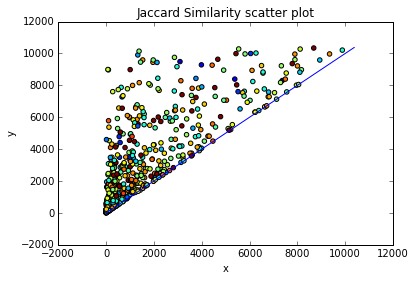

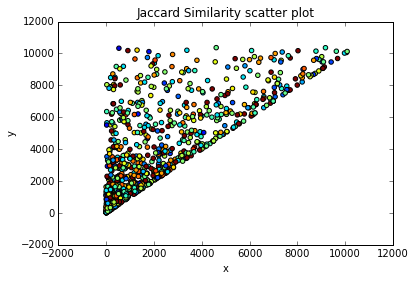

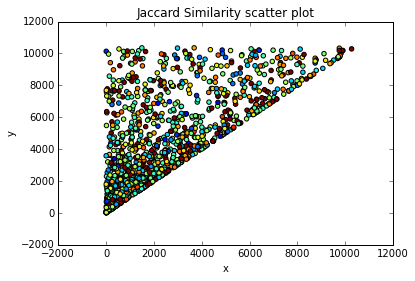

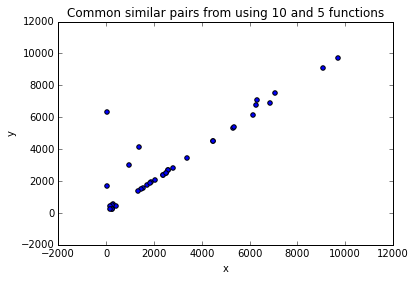

In [306]:
import matplotlib.pyplot as plt
from matplotlib import interactive
%pylab inline 
plt.figure(1)
plt.plot([0, 10377], [0, 10377])
scatter(x=lsh_key0_3,y=lsh_key1_3,c=dict(true_jaccard_3).values(),label='LSH_3_functions')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Jaccard Similarity scatter plot')
plt.figure(2)
scatter(x=lsh_key0_5,y=lsh_key1_5,c=dict(true_jaccard_5).values(),label='LSH_5_functions')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Jaccard Similarity scatter plot')
plt.figure(3)
scatter(x=lsh_key0_10,y=lsh_key1_10,c=dict(true_jaccard_10).values(),label='LSH_10_functions')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Jaccard Similarity scatter plot')
plt.figure(4)
scatter(inters_5_10_x, inters_5_10_y,label='Intersection of 10 and 5')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Common similar pairs from using 10 and 5 functions')
plt.show()

We see that the slop is flat, the similarity always has a lower probability of same bucket in any band:

Populating the interactive namespace from numpy and matplotlib


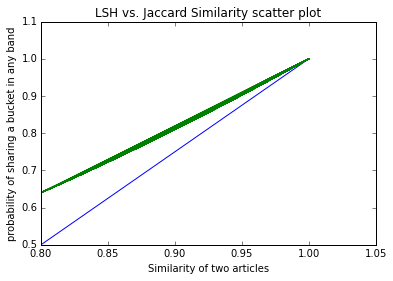

In [262]:
import matplotlib.pyplot as plt
from matplotlib import interactive
from pivottablejs import pivot_ui
interactive(True)
%matplotlib notebook 
%pylab inline 

plt.figure(1)
plt.plot([0.8, 1], [0.5, 1])
plt.plot(dict(lsh_10).values(),lsh_pro_iden)
plt.xlabel('Similarity of two articles')
plt.ylabel('probability of sharing a bucket in any band')
plt.title('LSH vs. Jaccard Similarity scatter plot')
plt.legend(loc='best')
plt.show()

Take the case of 10 fucntions, we see a kind of pattern that some of the spots from both graphs have very close colors, which means two articles are estimated to have high similarity in both systems. However, We see that LSH has much more blurish spots that stands for high similarity, thus it has probably many false positive.

Populating the interactive namespace from numpy and matplotlib


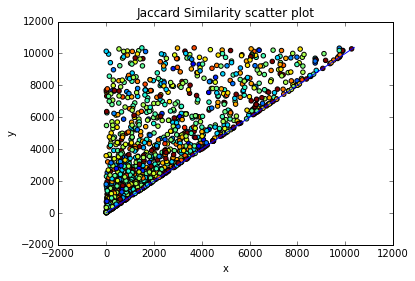

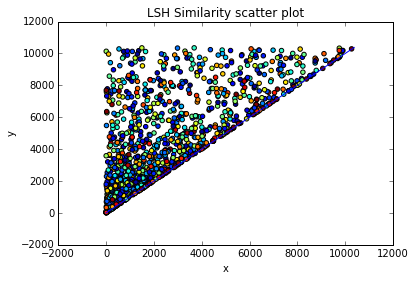

In [292]:
import matplotlib.pyplot as plt
from matplotlib import interactive
%pylab inline 
plt.figure(1)
plt.plot([0, 10377], [0, 10377])
scatter(x=ja_key0,y=ja_key1,c=dict(true_jaccard_10).values(),label='Jaccard')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Jaccard Similarity scatter plot')
plt.show()
plt.figure(2)
plt.plot([0, 10377], [0, 10377])
scatter(x=lsh_key0_10,y=lsh_key1_10,c=dict(lsh_10).values(),label='LSH')
plt.xlabel('x')
plt.ylabel('y')
plt.title('LSH Similarity scatter plot')

Another interesting plot discovers that for the same amount of spots, LSH similarity is 0.8 to 1, which becasue we set threshold, on the other hand, Jaccard similairity is among 0.3 to 1.

Populating the interactive namespace from numpy and matplotlib


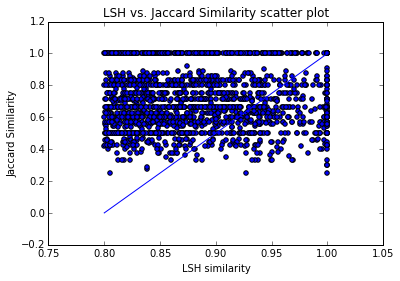

In [250]:
import matplotlib.pyplot as plt
from matplotlib import interactive
from pivottablejs import pivot_ui
interactive(True)
%matplotlib notebook 
%pylab inline 

plt.figure(1)
plt.plot([0.8, 1], [0, 1])
scatter(dict(lsh).values(),dict(true_jaccard).values())
plt.xlabel('LSH similarity')
plt.ylabel('Jaccard Similarity')
plt.title('LSH vs. Jaccard Similarity scatter plot')
plt.legend(loc='best')
plt.show()